# Leagues Comparison

In [1]:
'''
Let's start by importing the datasets and the important libraries
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import networkx as nx
from collections import Counter

data_partite = pd.read_csv("data_1/data_matches.csv", encoding='latin-1')
campionati = pd.read_csv("data_1/League_Clubs.csv", encoding='utf-8-sig')

In [2]:
def transformation(dataset, column, retain, new_col_names):
    new_data = dataset.merge(campionati, left_on= column, right_on = "Club", how='outer').fillna(0)
    new_data = new_data[(new_data['League'] != 0) & (new_data[column] != 0)]
    new_data = new_data[retain]
    new_data.columns = new_col_names
    new_data['DR'] = new_data['DR'].apply(lambda x: int(x))
    new_data = new_data.reset_index()
    new_data = new_data.drop(['index'],axis = 1)
    return new_data

df3 = transformation(data_partite, 'Home_Team', ["League","Away_Team","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df4 = transformation(df3, "Away_Team", ["Home_Team","League","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df5 = transformation(df4, "Winner", ["Home_Team","Away_Team","League","DR"], ['Home_League',"Away_League","Winner","DR"])

df5 = df5[df5["Home_League"] != df5["Away_League"]]
df5 = df5.reset_index()
df5 = df5.drop(['index'],axis = 1)

In [3]:
listone = [(df5['Home_League'][i], df5['Away_League'][i]) for i in range(len(df5))]
hh = Counter(listone).most_common()

nuova_lista = {}

for i in range(len(hh)):
    if (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) not in nuova_lista.keys()):
        nuova_lista[hh[i][0]] = hh[i][1]
    elif (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[(hh[i][0][1], hh[i][0][0])] += hh[i][1]
    elif (hh[i][0] in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[hh[i][0]] += hh[i][1]

In [4]:
df_a = pd.DataFrame(index = df5.Home_League.unique(),columns = df5.Home_League.unique())
df_a = df_a.fillna(0)

nazioni = df5.Home_League.unique()

for i in range(len(df5)):
    a = Counter(df5.iloc[i][:3].values)
    rev = {v: k for k, v in a.items()}
    loser = rev[1]
    df_a[df5.iloc[i]['Winner']][loser] += df5.iloc[i][3]
    
for i in range(len(list(nuova_lista.keys()))):
    df_a.loc[list(nuova_lista.keys())[i][0],list(nuova_lista.keys())[i][1]] /= nuova_lista[list(nuova_lista.keys())[i]]
    df_a.loc[list(nuova_lista.keys())[i][1],list(nuova_lista.keys())[i][0]] /= nuova_lista[list(nuova_lista.keys())[i]]
    
v = pd.DataFrame(columns = ['vincente',"perdente","di quanto"])
for k in range(len(df_a)):
    for j in range(len(df_a)):
        v = v.append({'vincente': df_a.index[k],'perdente': df_a[df_a.index[k]].index[j],'di quanto':df_a[df_a.index[k]][j]}, ignore_index = True)

v = v[v['vincente'] != v['perdente']]

In [5]:
a = list(set([i for i in v['vincente']]))
b = list(set([i for i in v['perdente']]))
c = list(set(a+b))
subset = v[['perdente', 'vincente','di quanto']]
tuples = [tuple(x) for x in subset.to_numpy()]
tuples = [x for x in tuples if x[2] != 0] 

G = nx.DiGraph()
G.add_nodes_from(c)
G.add_weighted_edges_from(tuples)
G.in_edges(data=True)

InEdgeDataView([('Ligue 1', 'Swiss Super League', {'weight': 0.16666666666666666}), ('Premier League', 'Swiss Super League', {'weight': 0.375}), ('Cypro League', 'Swiss Super League', {'weight': 1.0}), ('Serie A', 'Swiss Super League', {'weight': 0.5416666666666666}), ('Fußball-Bundesliga', 'Swiss Super League', {'weight': 0.5789473684210527}), ('Superliga', 'Swiss Super League', {'weight': 0.6666666666666666}), ('Divizia Nasional', 'Swiss Super League', {'weight': 2.0}), ('Croatian First Football League', 'Swiss Super League', {'weight': 0.6}), ('Ukrainian Premier League', 'Swiss Super League', {'weight': 0.6666666666666666}), ('Dutch Eredivisie', 'Swiss Super League', {'weight': 0.9}), ('Czech First League', 'Swiss Super League', {'weight': 0.4444444444444444}), ('Allsvenskan', 'Swiss Super League', {'weight': 0.75}), ('Süper Lig', 'Swiss Super League', {'weight': 1.25}), ('Belgian First Division A', 'Swiss Super League', {'weight': 0.6666666666666666}), ('First Professional Football

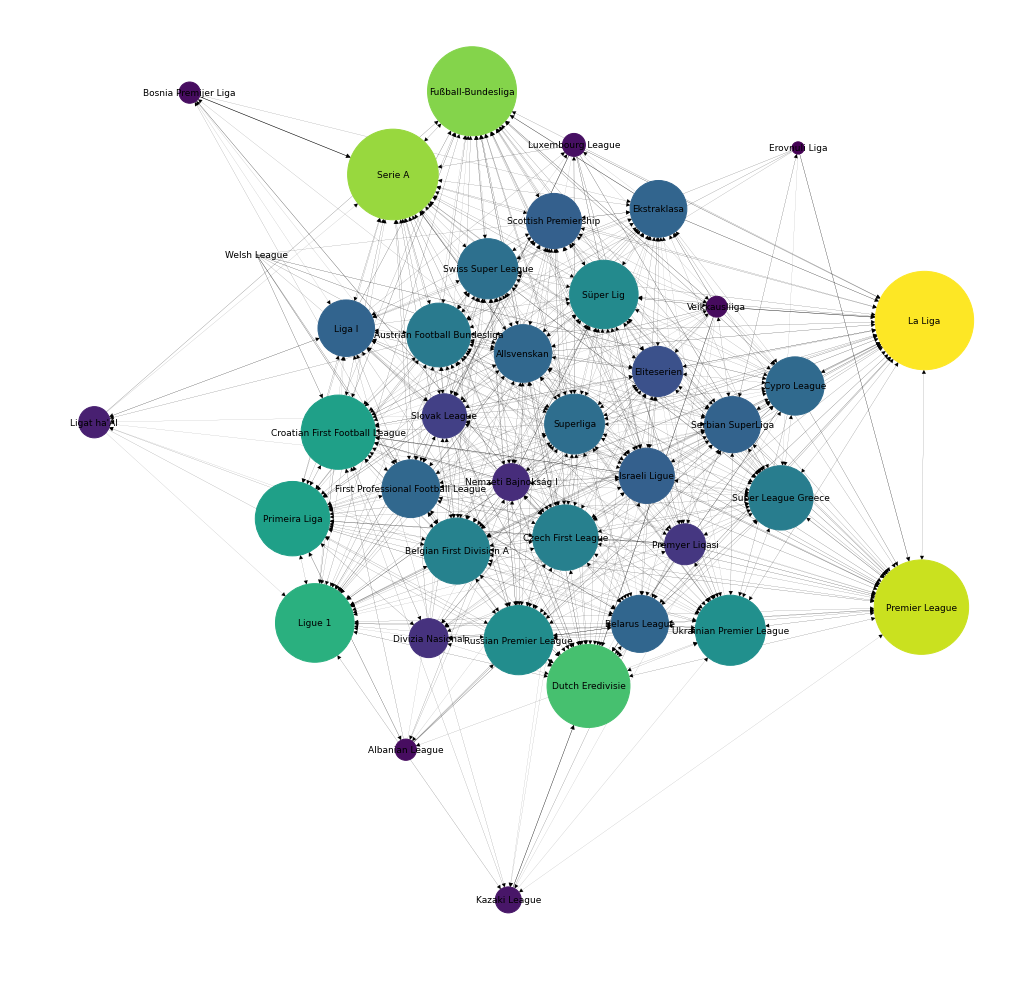

In [8]:
pos = nx.spring_layout(G, weight = 'weight', iterations=50000, threshold=0.000001)

node_size = [150 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
node_color = [50 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
weights = [G[i][j]['weight'] * 0.07 for i,j in G.edges()]

plt.figure(figsize = (18,18))
           
nx.draw_networkx(G, 
                 pos,
                 with_labels = False,
                 node_color = node_color,
                 node_size = node_size, 
                 width = weights)

nx.draw_networkx_labels(G, pos = pos, font_color = "black", font_size = 9)

plt.box(on = None)
plt.axis('off')

plt.show()

In [7]:
lista_j = [[i, np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))])] for i in G]
lista_j = [j for j in lista_j if ~np.isnan(j[1])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X = [np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
X = [j for j in X if ~np.isnan(j)]
X.append(0)

scaled_x = NormalizeData(X)

y = [[lista_j[i][0], scaled_x[i]] for i in range(len(lista_j))]

diz={}

for i in range(len(y)):
    diz[y[i][0]] = y[i][1]
    
diz = {k: v for k, v in sorted(diz.items(), key=lambda item: item[1], reverse=True)}
diz

{'La Liga': 1.0,
 'Premier League': 0.8921572193682004,
 'Fußball-Bundesliga': 0.8178832721455287,
 'Serie A': 0.7967541368114532,
 'Dutch Eredivisie': 0.6882201170284241,
 'Ligue 1': 0.6598492939517713,
 'Croatian First Football League': 0.630288634073032,
 "Ligat ha'Al": 0.6246378421829322,
 'Primeira Liga': 0.5911058441319106,
 'Russian Premier League': 0.5901077769703338,
 'Ukrainian Premier League': 0.5829440401035018,
 'Cypro League': 0.5722754186562665,
 'Süper Lig': 0.5361380811313926,
 'First Professional Football League': 0.5343014402981345,
 'Liga I': 0.5108229200062936,
 'Premyer Liqasi': 0.4863147768976674,
 'Belgian First Division A': 0.4807397397789194,
 'Bosnia Premijer Liga': 0.48049064783302475,
 'Erovnuli Liga': 0.48049064783302475,
 'Czech First League': 0.4719463511304742,
 'Israeli Ligue': 0.4643397016873768,
 'Austrian Football Bundesliga': 0.4637790932888755,
 'Super League Greece': 0.4566246670493039,
 'Belarus League': 0.453282740548898,
 'Allsvenskan': 0.4429

In [9]:
second_ranking = pd.read_csv('data_1/SPI_Index.csv')

diz2={}

for i in range(len(second_ranking)):
    diz2[second_ranking['League'][i]] = second_ranking['Average SPI'][i]
    
diz2

{'Premier League': 1.0,
 'La Liga': 0.9560049187047412,
 'Fußball-Bundesliga': 0.946030878535319,
 'Serie A': 0.8768957507856265,
 'Ligue 1': 0.8308512091815823,
 'Primeira Liga': 0.7148517557043312,
 'Dutch Eredivisie': 0.7037846700368903,
 'Brasileiro Série A': 0.6738625495286241,
 'Mexican Primera Division Torneo Clausura': 0.648175980325181,
 'Russian Premier League': 0.6249487634922805,
 'English League Championship': 0.6024047000956415,
 'Austrian Football Bundesliga': 0.5916108758027052,
 'Belgian First Division A': 0.5849159721273398,
 'Süper Lig': 0.5452930728241563,
 'Swiss Super League': 0.5406476294575762,
 'Superliga': 0.5388714305232956,
 'MLS': 0.5381882770870338,
 'Argentina Primera Division': 0.5310834813499111,
 'Scottish Premiership': 0.5239786856127887,
 'Japanese J League': 0.4843557863096052,
 'German 2. Bundesliga': 0.4827162180625768,
 'Super League Greece': 0.4683699959010794,
 'Eliteserien': 0.4499248531220112,
 'Italy Serie B': 0.4361251537095232,
 'Spanish S

In [10]:
nuovo1 = pd.DataFrame.from_dict(diz, orient='index')
nuovo1 = nuovo1.reset_index()
nuovo2 = pd.DataFrame.from_dict(diz2, orient='index')
nuovo2 = nuovo2.reset_index()
nuovo3 = pd.merge(nuovo1, nuovo2, on = "index")
nuovo3.columns = ["League","Graph Index", "SPI Index"]

nuovo3['Tot Index'] = (nuovo3['SPI Index'] + nuovo3['Graph Index'])/2

valore_nuovo = [i for i in nuovo3['Tot Index']]
valore_nuovo.append(0)
scaled_tot = NormalizeData(valore_nuovo)

y = [[nuovo3['League'][i], scaled_tot[i]] for i in range(len(nuovo3['League']))]

diz3 = {}

for i in range(len(y)):
    diz3[y[i][0]] = y[i][1]
    
diz3 = {k: v for k, v in sorted(diz3.items(), key=lambda item: item[1], reverse=True)}
diz3

{'La Liga': 1.0,
 'Premier League': 0.9673581090078135,
 'Fußball-Bundesliga': 0.9017943328327132,
 'Serie A': 0.8556470751133715,
 'Ligue 1': 0.7621149051713477,
 'Dutch Eredivisie': 0.7116570995062192,
 'Primeira Liga': 0.6676658056161954,
 'Russian Premier League': 0.621192988240142,
 'Süper Lig': 0.5528775227577999,
 'Belgian First Division A': 0.5448123886170656,
 'Austrian Football Bundesliga': 0.5395640670425592,
 'Swiss Super League': 0.4958351706930697,
 'Superliga': 0.4771332220754753,
 'Super League Greece': 0.4728999677377658,
 'Scottish Premiership': 0.46712836644721417,
 'Allsvenskan': 0.42315733626976737,
 'Eliteserien': 0.40924139763834355}